In [2]:
import qsharp
from qsharp.estimator import LogicalCounts
import json

# Hamiltonian Simulation Resource Estimation

We put our circuit here to get estimated.

In [3]:
%%qsharp
import Std.Arrays.*;
import Std.Canon.*;
import Std.Convert.*;
import Std.Diagnostics.*;
import Std.Math.*;
import Std.Measurement.*;
import Microsoft.Quantum.Unstable.Arithmetic.*;
import Microsoft.Quantum.Unstable.StatePreparation.*;
import Std.ResourceEstimation.*;

function CreateZeroMatrix(n : Int) : Double[][] {
    return Repeated(Repeated(0.0, n), n);
}

operation RunProgram() : Unit {
    let n = 3;
    let t = 1. / 30.;
    let h = CreateZeroMatrix(n); 


    let numbits = 10;
    use qx = Qubit[n];

    ApplyColorHamiltonianSimulation(t, h, numbits, 0, 0, 0, qx);

    // DumpRegister
    ResetAll(qx);
} 

operation Oracle(H : Double[][], qx : Qubit[], qj : Qubit[], qy : Qubit[], qr : Qubit[]) : Unit is Adj + Ctl {
        // do nothing
}

operation UnweightedOracle(H : Double[][], qx : Qubit[], qj : Qubit[], qy : Qubit[], qr : Qubit) : Unit is Adj + Ctl {
        // do nothing
}


    operation ReverseQubits(qubits : Qubit[]) : Unit is Adj + Ctl {
        let length = Length(qubits);
        for i in 0..length / 2 - 1 {
            SWAP(qubits[i], qubits[length - i - 1]);
        }
    }


    // little-endian
    operation PreparePureStateDL(coefficients : Double[], qubits : Qubit[]) : Unit is Adj + Ctl {
        within {
            ReverseQubits(qubits);
        } apply {
            PreparePureStateD(coefficients, qubits);
        }
    }

    operation Zip4Op(Op : (Qubit[] => Unit is Adj + Ctl), qubits1 : Qubit[], qubits2 : Qubit[], qubits3 : Qubit[], qubits4 : Qubit[]) : Unit is Adj + Ctl {
        let length = Length(qubits1);
        Fact(length == Length(qubits2) and length == Length(qubits3) and length == Length(qubits4), "Zip4Op: qubits must be with the same length.");
        for i in 0..length-1 {
            Op([qubits1[i], qubits2[i], qubits3[i], qubits4[i]]);
        }
    }


    operation Zip2Op(Op : (Qubit[] => Unit is Adj + Ctl), qubits1 : Qubit[], qubits2 : Qubit[]) : Unit is Adj + Ctl {
        let length = Length(qubits1);
        Fact(length == Length(qubits2), "Zip2Op: qubits must be with the same length.");
        for i in 0..length-1 {
            Op([qubits1[i], qubits2[i]]);
        }
    }

    operation ApplyBitwiseCNOT(cQubits : Qubit[], tQubits : Qubit[]) : Unit is Adj + Ctl {
        let length = Length(cQubits);
        Fact(length == Length(tQubits), "ApplyBitwiseCNOT: two input qubits must be with the same length");
        for i in 0..length-1 {
            CNOT(cQubits[i], tQubits[i]);
        }
    }


    operation ApplyBitwiseXOR(qubits1 : Qubit[], qubits2 : Qubit[], tQubits : Qubit[]) : Unit is Adj + Ctl {
        let length = Length(qubits1);
        Fact(length == Length(qubits2), "ApplyBitwiseXOR: two input qubits must be with the same length");
        ApplyBitwiseCNOT(qubits1, tQubits);
        ApplyBitwiseCNOT(qubits2, tQubits);
    }

    function BoolAsInt(b : Bool) : Int {
        mutable ib = 0;
        if b {
            set ib = ib + 1;
        }
        ib
    }

    // little-endian
    function IntToBinaryVector(n : Int, numBits : Int) : Bool[] {
        mutable bin = Repeated(false, numBits);
        mutable temp = n;

        for i in 0..numBits - 1 {
            set bin w/= i <- (temp % 2 == 1);
            set temp = temp / 2;
        }
        bin
    }

    // little-endian
    function FracToBinaryVector(frac : Double, numBits : Int) : Bool[] {
        mutable fracBin = Repeated(false, numBits);
        mutable fracValue = frac;
        for i in 0..numBits - 1 {
            set fracValue = fracValue * 2.0;
            let bit = fracValue >= 1.0;
            set fracBin w/= numBits - 1 - i <- bit;
            if bit {
                set fracValue = fracValue - 1.0;
            }
        }
        fracBin
    }

    // little-endian
    function BinaryVecToInt(bin : Bool[]) : Int {
        mutable n = 0;
        for i in 0..Length(bin) - 1 {
            if bin[i] {
                set n += 1 <<< i;
            }
        }
        n
    }

    function SumIntArray(intArr : Int[]) : Int {
        let add = (x, y) -> x + y;
        let total = Fold(add, 0, intArr);
        total
    }

    function SliceArray<'T>(arr : 'T[], i : Int, stepSize : Int) : 'T[] {
        let startIndex = i * stepSize;
        let endIndex = (i + 1) * stepSize - 1;
        return arr[startIndex..endIndex];
    }

    function GenerateZeroMatrix(n : Int) : Double[][] {
        Repeated(Repeated(0., n), n)
    }

    // Graph coloring
    // 
    //
    internal function GetFirst1AtNBitString(n : Int) : Bool[] {
        mutable bitString = Repeated(false, n + 1);
        set bitString w/= n <- true;
        bitString
    }

    operation GetLabel(
        preXiQubits : Qubit[],
        preYiQubits : Qubit[],
        xiQubits : Qubit[]
    ) : Unit is Adj + Ctl {
        // get the color label of the next xi
        // xi = position of the first different digit -- the different digit
        // xi Qubits is initially 0
        let lenPre = Length(preXiQubits);
        use aQubits = Qubit[lenPre];
        within {
            // if preXi[j] == preYi[j] then aQubis[j] == |0>
            ApplyBitwiseCNOT(preXiQubits, aQubits);
            ApplyBitwiseCNOT(preYiQubits, aQubits);
        } apply {
            for j in 0..lenPre - 1 {
                let first1AtNBitString = GetFirst1AtNBitString(j);
                // get position of the first digit
                ApplyControlledOnBitString(first1AtNBitString, ApplyXorInPlace(j, _), aQubits[0..j], xiQubits[0..Length(xiQubits)-2]);
                // copy the different digit to xi
                ApplyControlledOnBitString(first1AtNBitString, CNOT(preXiQubits[j], _), aQubits[0..j], xiQubits[Length(xiQubits)-1]);
            }
        }
    }

    internal function GetLogStarN(n : Int) : Int {
        mutable nIter = n;
        mutable logStarN = 1; // apply an additional round when nclock == 3
        while nIter > 3 {
            set nIter = Ceiling(Lg(IntAsDouble(nIter)));
            set logStarN += 1;
        }
        logStarN
    }

    internal function GetLenXiList(lenX0 : Int) : Int[] {
        let logStarN = GetLogStarN(lenX0);
        mutable lenXiList = Repeated(0, logStarN + 1);

        set lenXiList w/= 0 <- lenX0;

        for i in 1..logStarN - 1 {
            set lenXiList w/= i <- MaxI(Ceiling(Lg(IntAsDouble(lenXiList[i - 1]))), 3);
        }

        set lenXiList w/= logStarN <- 3;
        lenXiList
    }

    internal function GetTotalCoinQubitsNum(lenXiList : Int[]) : Int {
        // note that there might not be so many coin qubits in "path"
        mutable num = 0;
        let length = Length(lenXiList);
        for i in 0..length - 1 {
            let numVertices = length - i;
            set num += lenXiList[i] * numVertices;
        }
        num
    }


    internal operation CoinTossingStep(
        preRegLen : Int,
        regLen : Int,
        preVerticesRegs : Qubit[],
        verticesRegs : Qubit[]
    ) : Unit is Adj + Ctl {
        let numVertices = Length(verticesRegs) / regLen;
        Fact(Length(verticesRegs) % regLen == 0, "ConTossingStep: the regLen must divide verticesRegs.");
        Fact(Length(preVerticesRegs) % preRegLen == 0, "ConTossingStep: the preRegLen must divide preVerticesRegs.");
        Fact(Length(preVerticesRegs) / preRegLen == numVertices + 1, "CoinTossingStep: each step the number of vertices must reduce by 1.");

        for i in 0..numVertices - 1 {
            let preXiQubits = SliceArray(preVerticesRegs, i, preRegLen);
            let preYiQubits = SliceArray(preVerticesRegs, i + 1, preRegLen);
            let xiQubits = SliceArray(verticesRegs, i, regLen);
            GetLabel(preXiQubits, preYiQubits, xiQubits);
        }
    }


    internal operation FindNextVertexInPath(
        oracle : (Qubit[], Qubit[], Qubit[], Qubit) => Unit is Adj + Ctl,
        frontierVertexQubits : Qubit[],
        jQubits : Qubit[],
        kQubits : Qubit[],
        nextVertexQubits : Qubit[]
    ) : Unit is Adj + Ctl {
        // we want to find vertex in the path that's next to the current frontier,
        // the path is grown from small idx vertex to larger idx index : x0 < x1 < x2 < ...
        // so next vertex must be larger than frontier
        // that suggest that next vertex could only be frontier's jth neibour

        let length = Length(frontierVertexQubits);
        use aFrontierVertexQubits = Qubit[length];
        use aNextVertexQubits = Qubit[length];
        use arQubits = Qubit[2];


        within {
            oracle(frontierVertexQubits, jQubits, aNextVertexQubits, arQubits[0]);
            oracle(aNextVertexQubits, kQubits, aFrontierVertexQubits, arQubits[1]);
        } apply {
            Controlled ApplyIfEqualLE(
                arQubits,
                (
                    ApplyBitwiseCNOT,
                    aFrontierVertexQubits,
                    frontierVertexQubits,
                    (aNextVertexQubits, nextVertexQubits)
                )
            );
        }

    }

    function GetXiRegsTotalRange(lenXiList : Int[], i : Int) : (Int, Int) {
        mutable startIdx = 0;
        let maxVerticesNum = Length(lenXiList);

        // let
        for r in 0..i-1 {
            set startIdx += lenXiList[r] * (maxVerticesNum - r);
        }

        let range = lenXiList[i] * (maxVerticesNum - i);
        let endIdx = startIdx + range - 1;

        (startIdx, endIdx)
    }

    internal function GetSupplyQubitsNum(lenX0 : Int) : Int {
        mutable n = 0;
        if lenX0 < 3 {
            set n = 3 - lenX0;
        }
        n
    }

    internal operation DeterministicCoinTossing(
        unweightedOracle : (Qubit[], Qubit[], Qubit[], Qubit) => Unit is Adj + Ctl,
        smallVertexQubits : Qubit[],
        largeVertexQubits : Qubit[],
        jQubits : Qubit[],
        kQubits : Qubit[],
        colorQubits : Qubit[]
    ) : Unit is Adj + Ctl {

        body (...) {
            Controlled DeterministicCoinTossing([], (unweightedOracle, smallVertexQubits, largeVertexQubits, jQubits, kQubits, colorQubits));
        }


        controlled (ctrls, ...) {
            if Length(ctrls) >= 2 {
                use control = Qubit();
                within {
                    Controlled X(ctrls, control);
                } apply {
                    Controlled DeterministicCoinTossing([control], (unweightedOracle, smallVertexQubits, largeVertexQubits, jQubits, kQubits, colorQubits));
                }
            } else {
                // prepare the color qubits
                // it is guaranteed that x < y
                // the color qubits is initially |j>|k>|000>
                // we assign the additional 3 digits color
                let lenX0Reg = Length(smallVertexQubits);
                let supX0Num = GetSupplyQubitsNum(lenX0Reg);
                use axQubits = Qubit[supX0Num];
                use ayQubits = Qubit[supX0Num];

                let lenSupX0Reg = lenX0Reg + supX0Num;


                let logStarN = GetLogStarN(lenSupX0Reg);
                let lenXiList = GetLenXiList(lenSupX0Reg);
                let numCoinQubits = GetTotalCoinQubitsNum(lenXiList);
                use aQubits = Qubit[numCoinQubits - 2 * lenSupX0Reg - 3]; // the last three are clock qubits

                let totalQubits = smallVertexQubits + axQubits + largeVertexQubits + ayQubits + aQubits + colorQubits;

                // for the first round, find all the near vertices connected in the path
                let numVertices = logStarN + 1;
                within {
                    for i in 2..numVertices -1 {
                        let prevQubits = SliceArray(totalQubits, i-1, lenSupX0Reg);
                        let nextQubits = SliceArray(totalQubits, i, lenSupX0Reg);
                        FindNextVertexInPath(unweightedOracle, prevQubits[0..lenX0Reg-1], jQubits, kQubits, nextQubits[0..lenX0Reg-1]);
                    }

                    for i in 1..logStarN - 1 {
                        let (preXiRegsStartIdx, preXiRegsEndIdx) = GetXiRegsTotalRange(lenXiList, i - 1);
                        let (xiRegsStartIdx, xiRegsEndIdx) = GetXiRegsTotalRange(lenXiList, i);
                        CoinTossingStep(
                            lenXiList[i-1],
                            lenXiList[i],
                            totalQubits[preXiRegsStartIdx..preXiRegsEndIdx],
                            totalQubits[xiRegsStartIdx..xiRegsEndIdx]
                        );
                    }
                } apply {
                    // the last
                    let (preXiRegsStartIdx, preXiRegsEndIdx) = GetXiRegsTotalRange(lenXiList, logStarN - 1);
                    let (xiRegsStartIdx, xiRegsEndIdx) = GetXiRegsTotalRange(lenXiList, logStarN);
                    Controlled CoinTossingStep(
                        ctrls,
                        (
                            lenXiList[logStarN-1],
                            lenXiList[logStarN],
                            totalQubits[preXiRegsStartIdx..preXiRegsEndIdx],
                            totalQubits[xiRegsStartIdx..xiRegsEndIdx]
                        )
                    );
                }
            }
        }

    }

    operation GraphColoringOracle(h : Double[][], xQubits : Qubit[], cQubits : Qubit[], yQubits : Qubit[], rQubits : Qubit[]) : Unit is Adj + Ctl {
        // Input: vertex x, colour c = (om1, om2, f, g).
        // Output : m(x), w(x), where m(x) is the vertex y that shares an edge of colour c
        // with x, the weight w(x) of that edge, or m(x) = x and w(x) = O if the edge does
        // not exist.
        let gco = Oracle(h, _, _, _, _);
        let gcoUnWeighted = UnweightedOracle(h, _, _, _, _);

        Fact((Length(cQubits) - 3) % 2 == 0, "GraphColoringOracle: Length(cQubits) must be 2k + 3.");
        let lenOrdMark = (Length(cQubits) - 3) / 2;
        let lenX = Length(xQubits);
        use ayQubits = Qubit[lenX];
        use axQubits = Qubit[lenX];
        use condQubits = Qubit[2];
        use arQubits = Qubit[2];

        let firstOrdMarkQubits = cQubits[0..lenOrdMark-1];
        let SecOrdMarkQubits = cQubits[lenOrdMark..2 * lenOrdMark-1];
        let colorQubits = cQubits[Length(cQubits) - 3..Length(cQubits) - 1];


        // we define that y is x's jth neighbour and x is y's kth neighbour
        // (firstOrdMark, SecOrdMark) = (j, k) if x <= y
        // (firstOrdMark, SecOrdMark) = (k, j) if x > y
        //
        // so there are two possibilities :
        // 1. x <= y: x --(j,k)-- y first order mark is j
        // 2. x >  y: x --(k,j)-- y first order mark is k

        // try first possibility:
        let p0JQubits = firstOrdMarkQubits;
        let p0KQubits = SecOrdMarkQubits;

        within {
            gcoUnWeighted(xQubits, p0JQubits, ayQubits, arQubits[0]);
            gcoUnWeighted(ayQubits, p0KQubits, axQubits, arQubits[1]);
            ApplyIfEqualLE(X, axQubits, xQubits, (condQubits[0]));
            ApplyIfLessOrEqualLE(X, xQubits, ayQubits, condQubits[1]);
            Controlled DeterministicCoinTossing(arQubits + condQubits, (gcoUnWeighted, xQubits, ayQubits, p0JQubits, p0KQubits, colorQubits));
        } apply {
            within {
                // I used a trick here to reduce need for aColorQubits
                ApplyToEachCA(X, colorQubits);
            } apply {
                Controlled gco(arQubits + condQubits + colorQubits, (xQubits, p0JQubits, yQubits, rQubits));
            }
        }


        // try second possibility (this may actually be combined into the first one, let's do this later if needed)
        let p1JQubits = SecOrdMarkQubits;
        let p1KQubits = firstOrdMarkQubits;

        within {
            gcoUnWeighted(xQubits, p1JQubits, ayQubits, arQubits[0]);
            gcoUnWeighted(ayQubits, p1KQubits, axQubits, arQubits[1]);
            ApplyIfEqualLE(X, axQubits, xQubits, (condQubits[0]));
            ApplyIfGreaterLE(X, xQubits, ayQubits, condQubits[1]);
            Controlled DeterministicCoinTossing(arQubits + condQubits, (gcoUnWeighted, ayQubits, xQubits, p1JQubits, p1KQubits, colorQubits));
        } apply {
            within {
                // I used a trick here to reduce need for aColorQubits
                ApplyToEachCA(X, colorQubits);
            } apply {
                use control = Qubit();
                within {
                    Controlled X(arQubits + condQubits + colorQubits, control);
                } apply {
                    Controlled gco([control], (xQubits, p1JQubits, yQubits, rQubits));
                }
            }
        }

    }



    // Hamiltonian simulation
    operation WGate(qubits : Qubit[]) : Unit is Adj + Ctl {
        within {
            CNOT(qubits[0], qubits[1]);
            CNOT(qubits[1], qubits[0]);
        } apply {
            Controlled H([qubits[1]], (qubits[0]));
        }
    }

    internal operation NCNOT(cnQubits : Qubit[], tQubit : Qubit) : Unit is Adj + Ctl {

        within {
            X(cnQubits[0]);
        } apply {
            CCNOT(cnQubits[1], cnQubits[0], tQubit);
        }
    }

    internal operation U1Gate(theta : Double, qubit : Qubit) : Unit is Adj + Ctl {
        Exp([PauliI], theta / 2., [qubit]);
        Rz(theta, qubit);
    }

    operation eZZFtGate(time : Double, pQubit : Qubit, rQubits : Qubit[]) : Unit is Adj + Ctl {

        let length = Length(rQubits);
        Fact((length - 1) % 3 == 0, "eZZFtGate: (Length(rQubits) - 1) % 3 == 0.");
        let nr = (length - 1) / 3;
        let deo = 2^(2 * nr);

        use parityQubit = Qubit();
        within {
            CNOT(pQubit, parityQubit);
            CNOT(Tail(rQubits), parityQubit);
        } apply {
            for i in 0..length-2 {
                let theta = - time * 2.^IntAsDouble(i) / IntAsDouble(deo); // little-endian
                Controlled U1Gate([parityQubit], (theta, rQubits[i]));
            }

            within {
                X(parityQubit); // controll: operate on zero
            } apply {
                for i in 0..length-2 {
                    let theta = time * 2.^IntAsDouble(i) / IntAsDouble(deo); // little-endian
                    Controlled U1Gate([parityQubit], (theta, rQubits[i]));
                }
            }
        }

    }

    operation ApplyOneSparseHamiltonianSimulation(time : Double, h : Double[][], numBits : Int, qx : Qubit[]) : Unit is Adj + Ctl {
        body (...) {
            Controlled ApplyOneSparseHamiltonianSimulation([], (time, h, numBits, qx));
        }

        controlled (ctrls, ...) {

            if Length(ctrls) >= 2 {
                use control = Qubit();
                within {
                    Controlled X(ctrls, control);
                } apply {
                    Controlled ApplyOneSparseHamiltonianSimulation([control], (time, h, numBits, qx));
                }
            } else {
                let nx = Length(qx);
                use qy = Qubit[nx];
                use qj = Qubit[nx];
                use qr = Qubit[numBits];
                use qa = Qubit();

                within {
                    Oracle(h, qx, qj, qy, qr);
                    Zip2Op(WGate, qx, qy);
                    Zip2Op(NCNOT(_, qa), qx, qy);
                } apply {
                    Controlled eZZFtGate(ctrls, (time, qa, qr));
                }
            }
        }
    }


    operation ApplyColorHamiltonianSimulation(
        time : Double,
        h : Double[][],
        numBits : Int,
        j : Int,
        k : Int,
        color : Int,
        qx : Qubit[]
    ) : Unit is Adj + Ctl {
        body (...) {
            Controlled ApplyColorHamiltonianSimulation([], (time, h, numBits, j, k, color, qx));
        }

        controlled (ctrls, ...) {
            if Length(ctrls) >= 2 {
                use control = Qubit();
                within {
                    Controlled X(ctrls, control);
                } apply {
                    Controlled ApplyColorHamiltonianSimulation([control], (time, h, numBits, j, k, color, qx));
                }
            } else {

                let nx = Length(qx);
                use qy = Qubit[nx];
                // use qc = Qubit[2 * nx + 3];

                use qr = Qubit[numBits];
                use qa = Qubit();

                // use qtemp1 = Qubit[nx];
                // use qtemp2 = Qubit[nx];

                within {
                    // prepare qc
                    // ApplyXorInPlace(j, qc[0..nx-1]);
                    // ApplyXorInPlace(k, qc[nx..2 * nx-1]);
                    // ApplyXorInPlace(color, qc[Length(qc) - 3..Length(qc) -1]);
                } apply {
                    within {
                        // GraphColoringOracle(h, qx, qc, qy, qr);
                        Zip2Op(WGate, qx, qy);
                        Zip2Op(NCNOT(_, qa), qx, qy);
                    } apply {
                        // Z(qa);
                        Controlled eZZFtGate(ctrls, (time, qa, qr));
                    }
                }
            }
        }
    }



Here we observe the logical resource of a single Hamiltonian simulation.

In [4]:
result = qsharp.estimate("RunProgram()", params=
                {"qubitParams": {
                        "name": "qubit_gate_ns_e3",
                    },
                #  "constraints": {
                #         "maxPhysicalQubits": 3000,
                #     },
                })
result

Runtime,3 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (5,200 nanosecs) multiplied by the 639 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,9.42M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (49) (with a logical error rate of 1.06e-8) multiplied by the clock frequency (192,307.69), which is the number of logical cycles per second."
Physical qubits,161.76k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 16,562 physical qubits to implement the algorithm logic, and 145,200 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,49,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 18$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 49$ logical qubits."
Algorithmic depth,639,"Number of logical cycles for the algorithm To execute the algorithm using _Parallel Synthesis Sequential Pauli Computation_ (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 54 arbitrary single-qubit rotations, and the 12 T gates, three multi-qubit measurements for each of the 6 CCZ and 0 CCiX gates in the input program, as well as 15 multi-qubit measurements for each of the 37 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,639,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 639. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,192.31k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 5 microsecs.
Number of T states,846,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 12 T gates, four T states for each of the 6 CCZ and 0 CCiX gates, as well as 15 for each of the 54 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,15,"Number of T factories capable of producing the demanded 846 T states during the algorithm's runtime The total number of T factories 15 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{846 \cdot 57,200\;\text{ns}}{1 \cdot 3,322,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,57,"Number of times all T factories are invoked In order to prepare the 846 T states, the 15 copies of the T factory are repeatedly invoked 57 times."
Physical algorithmic qubits,16.56k,"Number of physical qubits for the algorithm after layout The 16,562 are the product of the 49 logical qubits after layout and the 338 physical qubits that encode a single logical qubit."


Based our data for different size n, we know that the algorithm's resource grows like this:
numQubits
'numQubits': nBits  + 2n + 2,
'tCount': 4n,
'rotationCount': 54,
'rotationDepth': 37,
'cczCount': 2n,

Next we use the logical scaling to estimate the physical resources without refering to the circuit.

In [8]:
nBits = 10

hsruntimes = []
hsphysicalcounts = []
for n in range(1, 100):
    logical_counts = LogicalCounts({
        'numQubits': nBits + 2*n + 2,
        'tCount': 4*n,
        'rotationCount': 54,
        'rotationDepth': 37,
        'cczCount': 2*n,
    })
    est = logical_counts.estimate(params={
        "qubitParams": {
            "name": "qubit_gate_ns_e3",
        },
    })
    # print(est._data["physicalCounts"])
    hsruntimes.append(est._data['physicalCounts']['runtime'])
    hsphysicalcounts.append(est._data['physicalCounts']['physicalQubits'])


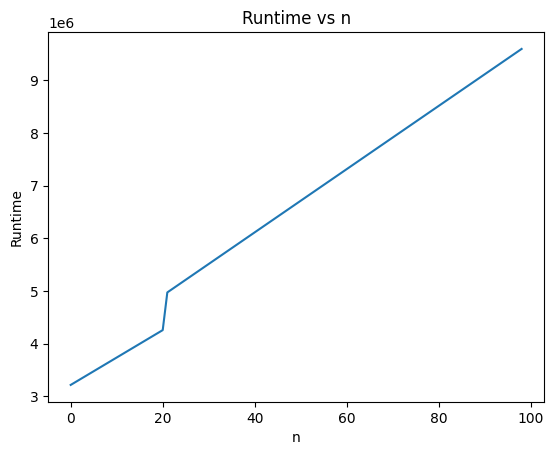

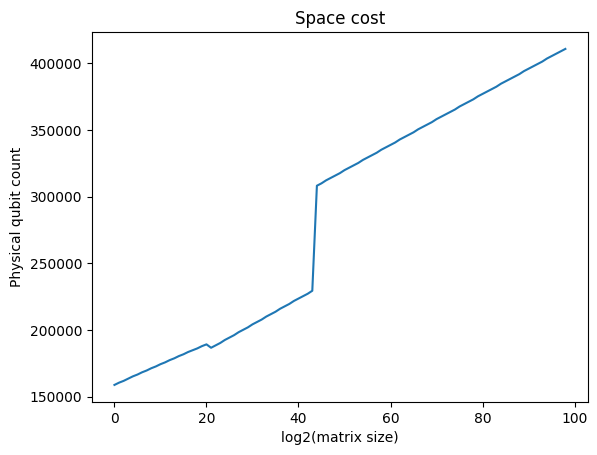

In [10]:
import matplotlib.pyplot as plt

plt.plot(hsruntimes)
plt.xlabel('n')
plt.ylabel('Runtime')
plt.title('Runtime vs n')
plt.show()

plt.plot(hsphysicalcounts)
plt.xlabel("log2(matrix size)")
plt.ylabel("Physical qubit count")
plt.title("Space cost")
plt.show()

This gives us the formula: per_hs_runtime = (3000000 + 70000 * np.log2(N)) * 1e-9